In [1]:
# importing libraries
import os 
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import ProbForecastFollmerProcess as pffp

from tqdm.notebook import tqdm
from torch.distributions import MultivariateNormal

In [2]:
# setting plotting style and defining the device
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "./data_store/multi_modal_jump_diffusion"
print('Computing on ' + str(device))

Computing on cuda


In [3]:
# setting reproducibility
reproducible = True
SEED = 1024 if reproducible else int(time.time())
pffp.utils.ensure_reproducibility(SEED)

In [4]:
# defining number of dimensions
dim = 2

# defining base gaussian component
mean_0 = torch.tensor([5.0, 0.0], device = device)
cov_0 = torch.tensor([[1.5, 0.0], [0.0, 0.1]], device = device)

# defining number of mixture models
K = 5

# defining rotation angle
theta = torch.tensor([2.0*np.pi/K], device = device)

# defining rotation matrix
R_theta = lambda k: torch.tensor([[torch.cos(k*theta), -torch.sin(k*theta)], [torch.sin(k*theta), torch.cos(k*theta)]], device = device)
rotations = [R_theta(k) for k in range(K)]

# defining mixture
gmm_params = [{"mean": torch.matmul(R, mean_0), "cov": torch.matmul(torch.matmul(R, cov_0), R.T)} for R in rotations]
gmm_components = [MultivariateNormal(params["mean"], params["cov"]) for params in gmm_params]
print(gmm_params)

[{'mean': tensor([5., 0.], device='cuda:0'), 'cov': tensor([[1.5000, 0.0000],
        [0.0000, 0.1000]], device='cuda:0')}, {'mean': tensor([1.5451, 4.7553], device='cuda:0'), 'cov': tensor([[0.2337, 0.4114],
        [0.4114, 1.3663]], device='cuda:0')}, {'mean': tensor([-4.0451,  2.9389], device='cuda:0'), 'cov': tensor([[ 1.0163, -0.6657],
        [-0.6657,  0.5837]], device='cuda:0')}, {'mean': tensor([-4.0451, -2.9389], device='cuda:0'), 'cov': tensor([[1.0163, 0.6657],
        [0.6657, 0.5837]], device='cuda:0')}, {'mean': tensor([ 1.5451, -4.7553], device='cuda:0'), 'cov': tensor([[ 0.2337, -0.4114],
        [-0.4114,  1.3663]], device='cuda:0')}]


In [5]:
# settings of the simulation
delta_t = torch.tensor([1e-2], device = device)
observation_interval = 50

# defining number of observations and iterations
num_iters = int(5e6) 
num_observations = int(num_iters / observation_interval)

# rate of the poisson process
poisson_rate = torch.tensor([2.0], device = device)

# defining the configuration dictionary
simulation_conf = {
    "delta_t": delta_t,
    "observation_interval": observation_interval,
    "num_iters": num_iters,
    "num_observations": num_observations,
    "poisson_rate": poisson_rate,
    "gmm_components": gmm_components,
    "R_theta": R_theta,
    "K": K,
    "dim": dim,
    "device": device
}

# checking if the simulation data is stored 
if len(os.listdir(data_folder)) == 0:
    print("Data not found, running the simulation")
    # simulating the trajectory we will use for training
    train_state_store, train_observation_store = pffp.utils.simulate_jump_diffusion(simulation_conf)
    # simulating the trajectory we will use for testing
    test_state_store, test_observation_store = pffp.utils.simulate_jump_diffusion(simulation_conf)
    # saving the simulations so that we won't have to run them again
    torch.save(train_state_store, os.path.join(data_folder, "train_states.pt"))
    torch.save(train_observation_store, os.path.join(data_folder, "train_observations.pt"))
    torch.save(test_state_store, os.path.join(data_folder, "test_states.pt"))
    torch.save(test_observation_store, os.path.join(data_folder, "test_observations.pt"))
else:
    print("Loading simulation data from disk")
    # loading training states and observations
    train_state_store = torch.load(os.path.join(data_folder, "train_states.pt"))
    train_observation_store = torch.load(os.path.join(data_folder, "train_observations.pt"))
    # loading testing states and observations
    test_state_store = torch.load(os.path.join(data_folder, "test_states.pt"))
    test_observation_store = torch.load(os.path.join(data_folder, "test_observations.pt"))
# printing shape of the data
print(f"{train_state_store.shape=}, {train_observation_store.shape=}")
print(f"{test_state_store.shape=}, {test_observation_store.shape=}")

Loading simulation data from disk
train_state_store.shape=torch.Size([5000000, 2]), train_observation_store.shape=torch.Size([100000, 2])
test_state_store.shape=torch.Size([5000000, 2]), test_observation_store.shape=torch.Size([100000, 2])


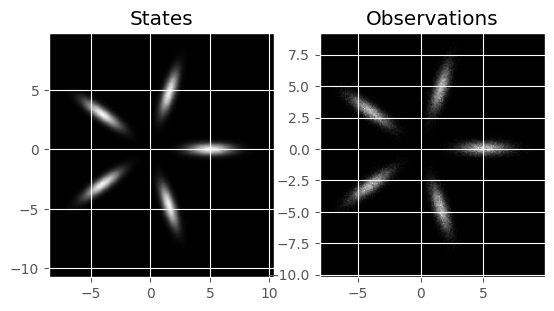

In [6]:
# defining figure and axes
fig, axes = plt.subplots(1, 2)

# plotting the states of the simulated dynamics
x = train_state_store[:,0].detach().cpu()
y = train_state_store[:,1].detach().cpu()
pffp.utils.plot_density(x, y, fig, axes[0], "States")
# plotting the observations of the simulated dynamics
x = train_observation_store[:,0].detach().cpu()
y = train_observation_store[:,1].detach().cpu()
pffp.utils.plot_density(x, y, fig, axes[1], "Observations")

In [7]:
# defining lag
tau_mul = 1 # 3 4
# sampling function for training data
get_train_data = lambda N: (i.to(device) for i in pffp.utils.sample_observations(N, train_observation_store, tau_mul))
# sampling function for testing data
get_test_data = lambda N: (i.to(device) for i in pffp.utils.sample_observations(N, test_observation_store, tau_mul))

In [8]:
# defining data configurations
data = {    
    "train": get_train_data, 
    "test": get_train_data, 
}

# defining sampling configurations
sample = {
    "g": pffp.interpolant["sigma"],#pffp.utils.g_follmer, 
    "N": 300
}

# learning standardization means and standard deviations
standardize = False
standardization = {
    'state_mean': torch.mean(train_observation_store, 0).to(device) if standardize else torch.zeros(dim).to(device),
    'state_std': torch.std(train_observation_store, 0).to(device) if standardize else torch.ones(dim).to(device) ,
}
print(standardization)

# defining network configurations
net_config = {
    "layers": [500]*5, 
    "standardization": standardization
}

# defining state configurations 
state = {
    "dim": dim
}

# defining optimization configurations
optim_config = {
    'minibatch': 1, 
    'num_obs_per_batch': 1000, 
    'num_iterations': 300,
    'learning_rate' : 0.001,
    'num_mc_samples': 200 
}

# defining model
model = pffp.core.model(data, sample, state, pffp.utils.interpolant, pffp.utils.velocity, net_config, device = "cuda")

# printing model
print(model)
# training model
model.train(optim_config)

{'state_mean': tensor([0., 0.], device='cuda:0'), 'state_std': tensor([1., 1.], device='cuda:0')}
model(
  (B_net): B_Network(
    (net): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=5, out_features=500, bias=True)
        (1-4): 4 x Linear(in_features=500, out_features=500, bias=True)
        (5): Linear(in_features=500, out_features=2, bias=True)
      )
      (activation_fn): ReLU()
    )
  )
)
Optimization iter: 1 Learning Rate: 0.000999972584682756 Loss: 24.05704116821289
Optimization iter: 50 Learning Rate: 0.0009330127018922197 Loss: 4.476664066314697
Optimization iter: 100 Learning Rate: 0.0007500000000000002 Loss: 2.3889994621276855
Optimization iter: 150 Learning Rate: 0.0005000000000000003 Loss: 2.2457783222198486
Optimization iter: 200 Learning Rate: 0.0002500000000000002 Loss: 2.1255993843078613
Optimization iter: 250 Learning Rate: 6.698729810778084e-05 Loss: 2.0138678550720215
Optimization iter: 300 Learning Rate: 0.0 Loss: 1.8401691913604736


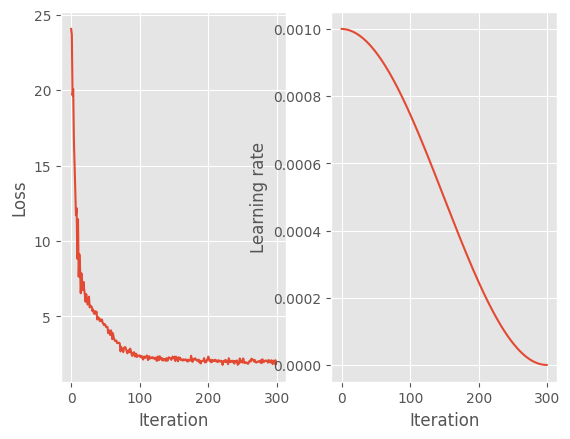

In [9]:
# retrieving loss and learning rates
losses = model.loss.detach().cpu()
lrs = model.lrs.detach().cpu()
# defining axes and figure
fig, axes = plt.subplots(1, 2)
# plotting loss
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")
axes[0].plot(losses)
# plotting learning rates
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Learning rate")
axes[1].plot(lrs)

In [17]:
# sampling configuration
sample_config = {
    "minibatch": 1, 
    "num_obs_per_batch": 1000,
    "num_samples_per_obs": 100
}

# running sampling
(X0, X1), samples = model.sample(sample_config)
print(f"{X0.shape=}, {X1.shape=}, {samples.shape=}")

10 samples generated
20 samples generated
30 samples generated
40 samples generated
50 samples generated
60 samples generated
70 samples generated
80 samples generated
90 samples generated
100 samples generated
110 samples generated
120 samples generated
130 samples generated
140 samples generated
150 samples generated
160 samples generated
170 samples generated
180 samples generated
190 samples generated
200 samples generated
210 samples generated
220 samples generated
230 samples generated
240 samples generated
250 samples generated
260 samples generated
270 samples generated
280 samples generated
290 samples generated
300 samples generated
310 samples generated
320 samples generated
330 samples generated
340 samples generated
350 samples generated
360 samples generated
370 samples generated
380 samples generated
390 samples generated
400 samples generated
410 samples generated
420 samples generated
430 samples generated
440 samples generated
450 samples generated
460 samples generat

/tmp/ipykernel_44816/2977508853.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


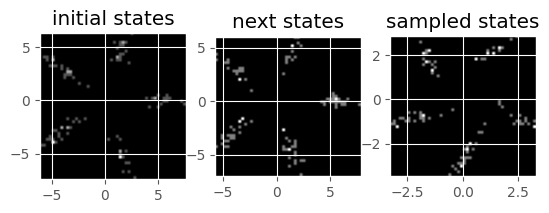

In [18]:
%matplotlib inline
# averaging the samples 
samples_avg = torch.mean(samples, dim = 0)
# retrieving the data
x_hat, y_hat = samples_avg[:, 0].detach().cpu(), samples_avg[:, 1].detach().cpu()
x0, y0 = X0[:, 0].detach().cpu(), X0[:, 1].detach().cpu()
x1, y1 = X1[:, 0].detach().cpu(), X1[:, 1].detach().cpu()

# defining axes and figure
fig, axes = plt.subplots(1, 3)

# plotting the distributions
pffp.utils.plot_density(x0, y0, fig, axes[0], title = "initial states", bins = 50)
pffp.utils.plot_density(x1, y1, fig, axes[1], title = "next states", bins = 50)
pffp.utils.plot_density(x_hat, y_hat, fig, axes[2], title = "sampled states", bins = 50)
fig.show()

/tmp/ipykernel_44816/2633835960.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


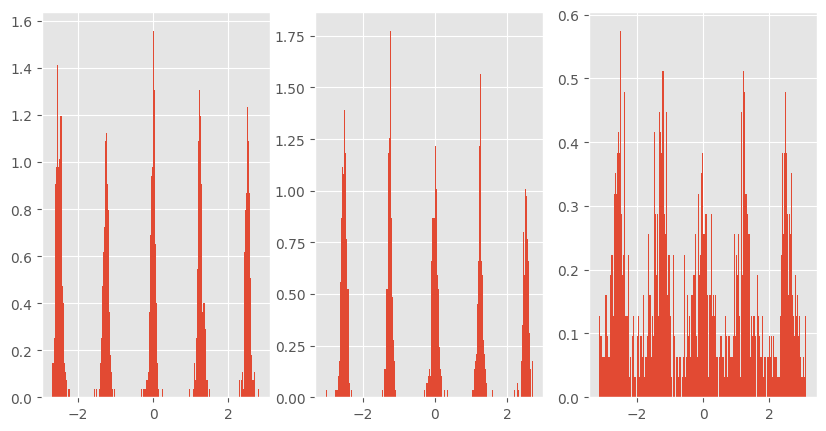

In [12]:
# converting to angular coordinates
theta_0 = pffp.utils.vec2angle(x0,y0)
theta_1 = pffp.utils.vec2angle(x1,y1)
theta_hat = pffp.utils.vec2angle(x_hat,y_hat)

# defining figure and axes
fig, axes = plt.subplots(1, 3, figsize = (10, 5))

# plotting the angular distributions
hist0 = axes[0].hist(theta_0, density = True, bins = 200)
hist1 = axes[1].hist(theta_1, density = True, bins = 200)
hist_hat = axes[2].hist(theta_hat, density = True, bins = 200)

# showing the figure
fig.show()